Nlp project code

Team-15

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
pip install ekphrasis

     |████████████████████████████████| 80 kB 3.8 MB/s 
     |████████████████████████████████| 45 kB 2.6 MB/s 
     |████████████████████████████████| 53 kB 1.6 MB/s 
  Created wheel for ekphrasis: filename=ekphrasis-0.5.1-py3-none-any.whl size=82842 sha256=7ff3162f1c13fe4170e8543f3c1a5933b9afdcec44d117c9fd6da9646c65a61f
  Stored in directory: /root/.cache/pip/wheels/f7/ec/0d/12659e32faf780546945d0120f2c8410eb3efb7426731da88f
Successfully built ekphrasis


In [1]:
import pandas as pd

import nltk
from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np
from tqdm import tqdm
from sklearn import utils
import re
import matplotlib.pyplot as plt
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
import codecs
from nltk.corpus import stopwords
import string
from scipy import sparse
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import TweetTokenizer
from math import log
import operator

from ekphrasis.classes.preprocessor import TextPreProcessor
from ekphrasis.classes.tokenizer import SocialTokenizer
from ekphrasis.dicts.emoticons import emoticons
from ekphrasis.classes.spellcorrect import SpellCorrector

## for bag-of-words
from sklearn import feature_extraction, feature_selection, model_selection, naive_bayes, pipeline, manifold, preprocessing
## for word embedding
import gensim
import gensim.downloader as gensim_api

from keras.datasets import mnist
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras import preprocessing
from keras.layers import Dense, Dropout, Conv2D, MaxPooling2D, Flatten
from keras.utils import np_utils
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, recall_score
from mlxtend.plotting import plot_confusion_matrix
from keras import datasets, layers, models, losses

In [2]:
text_processor = TextPreProcessor(
    # terms that will be normalized
    normalize=['url', 'email', 'percent', 'money', 'phone', 'user',
        'time', 'url', 'date', 'number'],
    # terms that will be annotated
    # annotate={"hashtag", "allcaps", "elongated", "repeated",
    #     'emphasis', 'censored'},
    fix_html=True,  # fix HTML tokens
    # corpus from which the word statistics are going to be used 
    # for word segmentation 
    # corpus from which the word statistics are going to be used 
    # for spell correction
    unpack_hashtags=True,  # perform word segmentation on hashtags
    unpack_contractions=True,  # Unpack contractions (can't -> can not)
    # select a tokenizer. You can use SocialTokenizer, or pass your own
    # the tokenizer, should take as input a string and return a list of tokens
    tokenizer=SocialTokenizer(lowercase=True).tokenize,
    # list of dictionaries, for replacing tokens extracted from the text,
    # with other expressions. You can pass more than one dictionaries.
    dicts=[emoticons])

/usr/local/lib/python3.7/dist-packages/ekphrasis/classes/tokenizer.py:225: FutureWarning: Possible nested set at position 2190
  self.tok = re.compile(r"({})".format("|".join(pipeline)))


Reading english - 1grams ...
Reading english - 2grams ...


/usr/local/lib/python3.7/dist-packages/ekphrasis/classes/exmanager.py:14: FutureWarning: Possible nested set at position 42
  regexes = {k.lower(): re.compile(self.expressions[k]) for k, v in


Reading english - 1grams ...


In [3]:
df = pd.read_csv('/content/drive/MyDrive/agr_en_train.csv', encoding='utf-8',header=None)
df.drop([0],axis=1,inplace=True)
df[2] = df[2].map({'NAG': 0, 'CAG': 1,'OAG': 2})
df

,1,2
0,Well said sonu..you have courage to stand agai...,2
1,"Most of Private Banks ATM's Like HDFC, ICICI e...",0
2,"Now question is, Pakistan will adhere to this?",2
3,Pakistan is comprised of fake muslims who does...,2
4,"??we r against cow slaughter,so of course it w...",0
...,...,...
11994,They belong to you flight dirty terrorist coun...,2
11995,"Really motivating programme, congratulations t...",0
11996,fabricated news,2
11997,What's wrong with you secular idiots,2


In [4]:
df1 = pd.read_csv('/content/drive/MyDrive/agr_en_dev.csv', encoding='utf-8',header=None)
df1.drop([0],axis=1,inplace=True)
df1[2] = df1[2].map({'NAG': 0, 'CAG': 1,'OAG': 2})
df1

,1,2
0,The quality of re made now makes me think it i...,1
1,@siva \nHow is ur mother???\nHow is ur wife???...,0
2,Also see ....hw ur RSS activist caught in Burk...,0
3,On the death of 2 jawans in LOC CROSS FIRING\n...,0
4,Modi ho ya Manmohan singh saala yeh log kuch n...,2
...,...,...
2996,Gaddaron se to yahi sahi hain.,0
2997,Just saw this news\n* read 1dt comment. \n*smi...,1
2998,U guys can crack jokes but can't take the crid...,1
2999,These media fellows have time to dissect one's...,1


In [5]:
df2 = pd.concat([df, df1],ignore_index=True)
df2

,1,2
0,Well said sonu..you have courage to stand agai...,2
1,"Most of Private Banks ATM's Like HDFC, ICICI e...",0
2,"Now question is, Pakistan will adhere to this?",2
3,Pakistan is comprised of fake muslims who does...,2
4,"??we r against cow slaughter,so of course it w...",0
...,...,...
14995,Gaddaron se to yahi sahi hain.,0
14996,Just saw this news\n* read 1dt comment. \n*smi...,1
14997,U guys can crack jokes but can't take the crid...,1
14998,These media fellows have time to dissect one's...,1


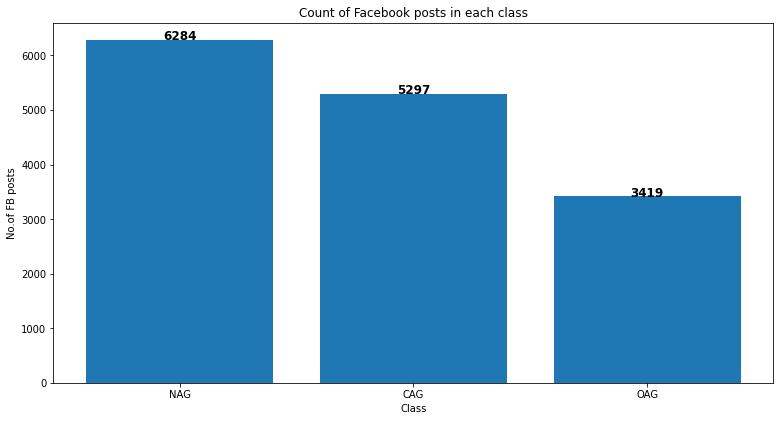

In [6]:
fig = plt.figure(figsize =(10,5))
ax = fig.add_axes([0,0,1,1])
def add_value_label(x_list,y_list):
    for i in range(1, len(x_list)+1):
        plt.text(i-1,y_list[i-1],y_list[i-1],ha="center",fontsize=12,fontweight="bold")
y_count = np.bincount(df2[2])
labels = ['NAG', 'CAG', 'OAG']
ax.bar(labels,y_count)
add_value_label(labels,y_count)
ax.set_xlabel('Class')
ax.set_ylabel('No.of FB posts')
ax.set_title('Count of Facebook posts in each class')
plt.show()

In [7]:
corpus = df2[1]
corpus

0        Well said sonu..you have courage to stand agai...
1        Most of Private Banks ATM's Like HDFC, ICICI e...
2           Now question is, Pakistan will adhere to this?
3        Pakistan is comprised of fake muslims who does...
4        ??we r against cow slaughter,so of course it w...
                               ...                        
14995                       Gaddaron se to yahi sahi hain.
14996    Just saw this news\n* read 1dt comment. \n*smi...
14997    U guys can crack jokes but can't take the crid...
14998    These media fellows have time to dissect one's...
14999    Middle class is suffering, but most affected a...
Name: 1, Length: 15000, dtype: object

In [8]:
def clean_data(corpus):
    new_corp = []
    # spell correct
    print("------ Correcting Spellings ------")
    for i in tqdm(range(len(corpus))):
        t = text_processor.pre_process_doc(corpus[i])
        t = [sp.correct(word) for word in t if word not in string.punctuation]
        new_corp.append(" ".join(t))
    new_corp2 = []
    # lemmatize
    print("----- Lemmatizing Text -----")
    for i in tqdm(range(len(corpus))):
        t = new_corp[i].split(" ")
        to_add = []
        for i in t:
            if i not in stop_words:
                to_add.append(wordnet_lemmatizer.lemmatize(i))
        new_corp2.append(" ".join(to_add))
    return new_corp2

In [9]:
import nltk
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [10]:
sp = SpellCorrector(corpus="english") 
wordnet_lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

lemmatized_data = clean_data(corpus)

all_words = set()
for i in range(len(corpus)):
    t = lemmatized_data[i].split(" ")
    all_words |= set(t)

all_words = list(all_words)

new_corp = lemmatized_data

Reading english - 1grams ...
------ Correcting Spellings ------


100%|██████████| 15000/15000 [04:28<00:00, 55.92it/s] 


----- Lemmatizing Text -----


100%|██████████| 15000/15000 [00:03<00:00, 4687.83it/s] 


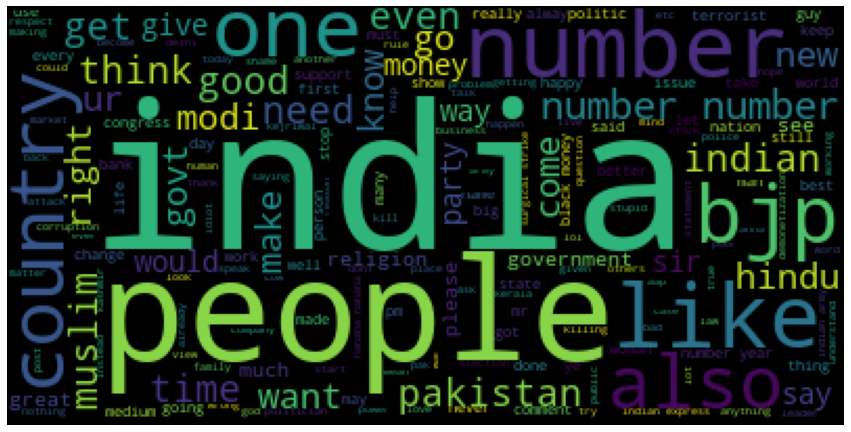

In [11]:
from wordcloud import WordCloud

text = " ".join(review for review in new_corp)
#print(len(text))
wordcloud = WordCloud(stopwords=stop_words).generate(text)

fig = plt.figure(figsize=(15, 10))
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

In [12]:
import seaborn as sns
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(new_corp, df2[2], test_size=0.2, random_state=12)

# BERT Language Model 

In [136]:
import transformers

def tokenize_bert(corpus, tokenizer=None, maxlen=None):
    tokenizer = transformers.BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True) if tokenizer is None else tokenizer
    maxlen = np.max([len(txt.split(" ")) for txt in corpus]) if maxlen is None else maxlen
    if maxlen < 20:
        raise Exception("maxlen cannot be less than 20")
    else:
        print("maxlen:", maxlen)

    ## add special tokens: [CLS] my name is mau ##ro [SEP]
    maxqnans = np.int((maxlen-20)/2)
    corpus_tokenized = ["[CLS] "+
                        " ".join(tokenizer.tokenize(re.sub(r'[^\w\s]+|\n', '', str(txt).lower().strip()))[:maxqnans])+
                        " [SEP] " for txt in corpus]
   
    ## generate masks: [1, 1, 1, 1, 1, 1, 1, | (padding) 0, 0, 0, 0, 0, ...]
    masks = [[1]*len(txt.split(" ")) + [0]*(maxlen - len(txt.split(" "))) for txt in corpus_tokenized]
    
    ## padding
    #corpus_tokenized = kprocessing.sequence.pad_sequences(corpus_tokenized, maxlen=maxlen, dtype=object, value='[PAD]')
    txt2seq = [txt + " [PAD]"*(maxlen-len(txt.split(" "))) if len(txt.split(" ")) != maxlen else txt for txt in corpus_tokenized]
    
    ## generate idx: [101, 22, 35, 44, 50, 60, 102, 0, 0, 0, 0, 0, 0, ...]
    idx = [tokenizer.encode(seq.split(" ")) for seq in txt2seq]
    
    ## generate segments: [0, 0, 0, 0, 0, 0, 1 [SEP], 0, 0, 0, 0, 2 [SEP], 0, ...]
    segments = [] 
    for seq in txt2seq:
        temp, i = [], 0
        for token in seq.split(" "):
            temp.append(i)
            if token == "[SEP]":
                i += 1
        segments.append(temp)
    
    ## check
    genLength = set([len(seq.split(" ")) for seq in txt2seq])
    if len(genLength) != 1: 
        print(genLength)
        raise Exception("--- texts are not of same size ---")

    X = [np.asarray(idx, dtype='int32'), np.asarray(masks, dtype='int32'), np.asarray(segments, dtype='int32')]
    print("created tensor idx-masks-segments:", str(len(X))+"x "+str(X[0].shape))
    return X

In [137]:
X_train = tokenize_bert(corpus=x_train, tokenizer=tokenizer, maxlen=50)
X_test = tokenize_bert(corpus=x_test, tokenizer=tokenizer, maxlen=50)

maxlen: 50


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  if sys.path[0] == '':


created tensor idx-masks-segments: 3x (12000, 52)
maxlen: 50
created tensor idx-masks-segments: 3x (3000, 52)


In [139]:
X_train[0] = X_train[0][:,:50]
X_test[0] = X_test[0][:,:50]

In [140]:
idx = layers.Input((50), dtype="int32", name="input_idx")
masks = layers.Input((50), dtype="int32", name="input_masks")
## pre-trained bert with config
config = transformers.DistilBertConfig(dropout=0.2, attention_dropout=0.2)
config.output_hidden_states = False
nlp = transformers.TFDistilBertModel.from_pretrained('distilbert-base-uncased', config=config)
bert_out = nlp(idx, attention_mask=masks)[0]
## fine-tuning
x = layers.GlobalAveragePooling1D()(bert_out)
x = layers.Dense(64, activation="relu")(x)
y_out = layers.Dense(len(np.unique(y_train)), activation='softmax')(x)
## compile
model = models.Model([idx, masks], y_out)
for layer in model.layers[:3]:
    layer.trainable = False
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

model.summary()

Some layers from the model checkpoint at distilbert-base-uncased were not used when initializing TFDistilBertModel: ['activation_13', 'vocab_transform', 'vocab_projector', 'vocab_layer_norm']
- This IS expected if you are initializing TFDistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFDistilBertModel were initialized from the model checkpoint at distilbert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertModel for predictions without further training.


Model: "model_8"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_idx (InputLayer)         [(None, 50)]         0           []                               
                                                                                                  
 input_masks (InputLayer)       [(None, 50)]         0           []                               
                                                                                                  
 tf_distil_bert_model_11 (TFDis  TFBaseModelOutput(l  66362880   ['input_idx[0][0]',              
 tilBertModel)                  ast_hidden_state=(N               'input_masks[0][0]']            
                                one, 50, 768),                                                    
                                 hidden_states=None                                         

In [127]:
dic_y_mapping = {n:label for n,label in enumerate(np.unique(y_train))}
inverse_dic = {v:k for k,v in dic_y_mapping.items()}
y_train = np.array( [inverse_dic[y] for y in y_train])
    
history = model.fit(x=X_train[:2], y=y_train, batch_size=64, epochs=10, validation_split=0.2)

Epoch 1/10
150/150 [==============================] - 56s 328ms/step - loss: 0.9360 - accuracy: 0.5341 - val_loss: 0.9609 - val_accuracy: 0.5125
Epoch 2/10
150/150 [==============================] - 49s 324ms/step - loss: 0.9252 - accuracy: 0.5422 - val_loss: 0.9429 - val_accuracy: 0.5358
Epoch 3/10
150/150 [==============================] - 49s 324ms/step - loss: 0.9143 - accuracy: 0.5536 - val_loss: 0.9436 - val_accuracy: 0.5321
Epoch 4/10
150/150 [==============================] - 49s 324ms/step - loss: 0.9049 - accuracy: 0.5615 - val_loss: 0.9323 - val_accuracy: 0.5542
Epoch 5/10
150/150 [==============================] - 49s 325ms/step - loss: 0.8989 - accuracy: 0.5646 - val_loss: 0.9368 - val_accuracy: 0.5383
Epoch 6/10
150/150 [==============================] - 49s 324ms/step - loss: 0.8940 - accuracy: 0.5673 - val_loss: 0.9299 - val_accuracy: 0.5550
Epoch 7/10
150/150 [==============================] - 49s 324ms/step - loss: 0.8831 - accuracy: 0.5726 - val_loss: 0.9405 - val_ac

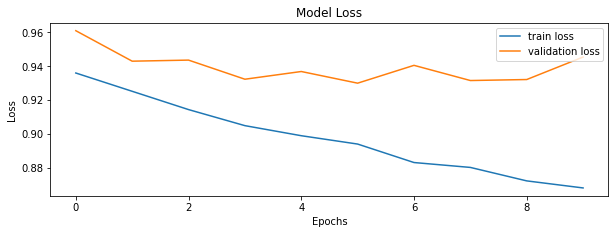

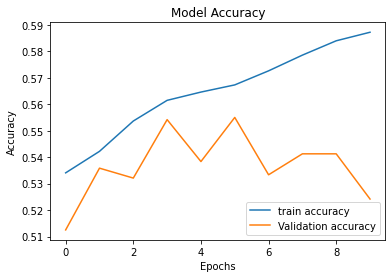

In [129]:
fig = plt.figure(figsize=(10, 7))

fig.add_subplot(2, 1, 1)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['train loss', 'validation loss'],loc='upper right')
plt.show()

fig.add_subplot(2, 1, 2)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train accuracy','Validation accuracy'],loc='lower right')
plt.show()

In [130]:
predicted_prob = model.predict(X_test[:2])
predicted = [dic_y_mapping[np.argmax(pred)] for pred in predicted_prob]

In [132]:
print(confusion_matrix(y_test,predicted))
print(classification_report(y_test,predicted))

[[816 248 183]
 [338 407 311]
 [118 179 400]]
              precision    recall  f1-score   support

           0       0.64      0.65      0.65      1247
           1       0.49      0.39      0.43      1056
           2       0.45      0.57      0.50       697

    accuracy                           0.54      3000
   macro avg       0.53      0.54      0.53      3000
weighted avg       0.54      0.54      0.54      3000

